## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import math

In [34]:
#Downloading the nltk libraries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/soumodiptab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/soumodiptab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/soumodiptab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load Dataset

In [35]:
"""from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/smai/
"""
data=pd.read_csv('emails.txt',sep='\t',header=None)
data.columns=['type','text']
data

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Preprocess data:
1. Removing Punctuation
2. Tokenizing
3. Converting to lower case
4. Removing stop words
5. Lemmatizing the tokens

In [36]:
# punctuations
punctuations=string.punctuation
# stopwords
stop_words=stopwords.words('english')
def remove_punctuations(text):
  for c in punctuations:
    text=text.replace(c," ")
  return text
wn = WordNetLemmatizer()
#removing stopwords
data['text'] = data['text'].apply(remove_punctuations)
#tokenizing the text
data['text'] = data['text'].apply(word_tokenize)
#removing the 
data['text'] = data['text'].apply(lambda x: ([word.lower() for word in x if word.lower() not in stop_words]))
#Lemmatizing
data['text'] = data['text'].apply(lambda x: [wn.lemmatize(word) for word in x])

In [37]:
data.sample(10)

,type,text
988,ham,"[geeee, miss, already, know, think, fuck, wait..."
1259,ham,"[honey, boo, missing, u]"
5502,ham,"[apo, mokka, player]"
4054,ham,"[slept, time]"
796,ham,"[really, getting, hanging, around]"
328,ham,"[say, good, sign, well, know, track, record, r..."
3933,ham,"[so, amount, get, pls]"
2048,ham,"[de, call, time, ill, tell, k]"
4342,ham,"[ü, write, wat]"
292,ham,"[haf, u, found, feel, stupid, da, v, cam, work..."


In [38]:
#removing lines with empty text
data=data[data['text'].map(lambda d: len(d)) > 0]
data.sample(10)

,type,text
782,ham,"[hmmm, thought, said, 2, hour, slave, 3, late,..."
4396,ham,"[got, message, ignoring, yes, shopping]"
3600,ham,"[wat, r, u, busy, wif, work]"
1964,ham,"[yes, completely, form, clark, also, utter, wa..."
2343,spam,"[double, min, txts, orange, 1, 2, price, liner..."
1351,ham,"[bugis, oso, near, wat]"
2358,ham,"[okay, well, thanks, clarification]"
5178,spam,"[sm, auction, brand, new, nokia, 7250, 4, auct..."
3255,ham,"[make, lasagna, vodka]"
554,ham,"[ok, every, night, take, warm, bath, drink, cu..."


#### Splitting Cleaned Data into test and train:

In [39]:
text_train, text_test,labels_train, labels_test = train_test_split(data['text'],data['type'] ,test_size=0.20, random_state=42)
labels_train=np.array(labels_train)
labels_test=np.array(labels_test)
text_train=np.array(text_train)
text_test=np.array(text_test)

##### Functions to calculate TF-IDF

In [40]:
def term_freq(sentence, word):
    N = len(sentence)
    freq = len([x for x in sentence if x==word])
    return freq/float(N)

def inverse_doc_freq(word,doc_word_count,total_sentences):
    doc_freq = doc_word_count[word] + 1
    return math.log10(total_sentences/float(doc_freq))

def tf_idf(sentence,doc_word_count,index_unique_words,unique_words,total_sentences):
    tf_idf_vector = np.zeros((len(unique_words),))
    for word in set(sentence):
      tf = term_freq(sentence,word)
      idf = inverse_doc_freq(word,doc_word_count,total_sentences)
      value = tf*idf
      tf_idf_vector[index_unique_words[word]] = value
    return tf_idf_vector
test_data=[]

In [41]:
def build_unique_words(data_frame_col):
  unique_words=set()
  for text in data_frame_col:
    unique_words=unique_words.union(set(text))
  return unique_words
def build_doc_freq(data_frame_col,unique_words):
  doc_word_count=dict.fromkeys(unique_words, 0)
  for text in data_frame_col:
    for word in unique_words:
      if word in text:
        doc_word_count[word]+=1
  return doc_word_count
def calc_tf_idf(data_frame_col):
  total_sentences=len(data_frame_col)
  unique_words=build_unique_words(data_frame_col)
  #for calculation of document freq:
  doc_word_count=build_doc_freq(data_frame_col,unique_words)
  print(doc_word_count)
  index_unique_words={}
  index=0
  for word in unique_words:
    index_unique_words[word]=index
    index+=1
  vectors=[]
  for sentence in data_frame_col:
    tf_idf_vector = tf_idf(sentence,doc_word_count,index_unique_words
                             ,unique_words,total_sentences)
    vectors.append(tf_idf_vector)
  return vectors,index_unique_words,doc_word_count,total_sentences
#labels=np.array(data['type'])
#vectors=calc_tf_idf(data['text'])
#test_data=data['text'].sample(10)
#vectors,index_dict=calc_tf_idf(test_data)
#test_data

##### Calculating the TF-IDF Vector for the Train Data

In [42]:
vectors_train,index_unique_words,doc_word_count,total_sentences=calc_tf_idf(text_train)

{'murderer': 5, 'pert': 1, 'armenia': 1, 'barrel': 1, 'discus': 4, '0125698789': 1, 'ondu': 1, '〨ud': 1, 'captain': 2, 'predicte': 1, 'feelin': 3, 'mega': 2, 'iff': 1, 'thanx4': 1, 'elaborate': 1, 'weiyi': 1, 'ntt': 5, 'keen': 1, '09050000460': 1, 'drunk': 3, 'phd': 1, 'sw7': 2, '09065069120': 1, 'or2stoptxt': 3, 'space': 6, 'mist': 1, 'thousand': 1, '07781482378': 1, 'unbelievable': 2, 'usa': 1, 'arrow': 1, 'inr': 1, 'laying': 1, 'borrow': 2, 'fried': 1, '08718727868': 2, 'bid': 4, 'termsapply': 1, '89693': 2, 'erutupalam': 1, 'jetton': 1, 'ralphs': 1, 'andros': 2, 'site': 3, 'yeesh': 1, 'raiden': 1, 'lavender': 1, 'shiny': 1, 'follow': 1, 'ip4': 5, 'taylor': 3, 'nic': 2, 'speak': 29, '09090204448': 1, 'everything': 25, 'hai': 4, 'minecraft': 1, 'scrumptious': 1, 'order': 17, 'persolvo': 1, 'open': 14, 'night': 85, 'complete': 8, 'magical': 2, 'gong': 1, 'track': 5, 'ugh': 8, 'japanese': 2, 'deltomorrow': 1, 'aww': 2, 'impress': 1, 'tooth': 1, 'vary': 4, 'nxt': 5, 'mi': 2, '82242': 2,

##### Calculating TF-IDF for Test data using Train Vector size

In [43]:
#testing data
def testing_tf_idf(data,index_unique_words,doc_word_count,total_sentences):
  vectors=[]
  for sentence in data:
    unique_words=index_unique_words.keys()
    vector=np.zeros((len(unique_words),))
    for word in set(sentence):
      if word not in unique_words:
        continue
      tf = term_freq(sentence,word)
      idf = inverse_doc_freq(word,doc_word_count,total_sentences+1)
      value = tf*idf
      vector[index_unique_words[word]] = value
    vectors.append(vector)
  return vectors
vectors_test=testing_tf_idf(text_test,index_unique_words,doc_word_count,total_sentences)

In [44]:
#labels_train, labels_test, vectors_train, vectors_test = train_test_split(labels, vectors, test_size=0.05, random_state=42)
print(len(index_unique_words))

7280


In [45]:
print(len(labels_test))
print(len(labels_train))
print(len(vectors_test))
print(len(vectors_train))
print()

1113
4452
1113
4452



### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

In [46]:
#Calculating cosine similarity
def cosine_distance(vector_a,vector_b):
  dot_product=np.dot(vector_a, vector_b)
  mag_a=math.sqrt(np.dot(vector_a, vector_a.T))
  mag_b=math.sqrt(np.dot(vector_b,vector_b.T))
  return (1.0-(dot_product/float(mag_a*mag_b)))
def euclidean_distance(vector_a,vector_b):
  return np.linalg.norm(vector_a - vector_b)
def manhattan_distance(a, b):
    return np.abs(a - b).sum()
def calc_distance(vector_a,vector_b,metric):
  if metric == "euclidean":
    return euclidean_distance(vector_a,vector_b)
  elif metric == "manhattan":
    return manhattan_distance(vector_a,vector_b)
  else:
    return cosine_distance(vector_a,vector_b)

Assigns class based on majority

In [47]:
def get_class(selected_values):
    s,h = 0,0
    for value in selected_values:
        if value == "spam":
            s += 1
        else:
            h += 1
    if s > h:
        return "spam"
    else:
        return "ham"

In [48]:
def score_display(y_true,y_pred,labels):
    print('Confusion matrix: ')
    print(confusion_matrix(y_true, y_pred,labels=labels))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels=labels).ravel()
    precision=tp/(tp+fp)
    print('Precision: ',end='')
    print(precision)
    recall=tp/(tp+fn)
    print('Recall: ',end='')
    print(recall)
    f1_score=2*(precision*recall)/(precision+recall)
    print('F1 Score: ',end='')
    print(f1_score)
    print('Accuracy: ',end='')
    print(accuracy_score(y_true,y_pred))
def f1_score(y_true,y_pred,labels):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels=labels).ravel()
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    f1_score=2*(precision*recall)/(precision+recall)
    return f1_score

Implementation of K-NN

In [49]:

def k_nearest_neighbours(k,train_data,train_labels,test_data,metric="cosine"):
  test_labels=[]
  for i in range(len(test_data)):
    k_labels=[]
    distances=[]
    for j in range(len(train_data)):
      distance=calc_distance(test_data[i],train_data[j],metric)
      distances.append((distance,train_labels[j]))
    top_k_labels=[]
    distances.sort()
    for j  in distances[:k]:
      top_k_labels.append(j[1])
    test_labels.append(get_class(top_k_labels))
  test_labels=np.array(test_labels)
  return test_labels
#testing_labels=k_nearest_neighbours(5,vectors_train,labels_train,vectors_test)

In [50]:
# k nearest neigbour using single k value
def k_nearest_neighbours(k_values,train_data,train_labels,test_data,metric="cosine"):
  test_labels=[]
  for i in range(len(test_data)):
    k_labels=[]
    distances=[]
    for j in range(len(train_data)):
      distance=calc_distance(test_data[i],train_data[j],metric)
      distances.append((distance,train_labels[j]))
    top_k_labels=[]
    distances.sort()
    for j  in distances[:k]:
      top_k_labels.append(j[1])
    test_labels.append(get_class(top_k_labels))
  test_labels=np.array(test_labels)
  return test_labels

In [51]:
#using an array of k-values
def k_nearest_neighbours_batch(k_values,train_data,train_labels,test_data,true_label,metric="cosine"):
    xtrue_label=np.array(true_label)
    all_distances=[]
    for i in range(len(test_data)):
        distances=[]
        for j in range(len(train_data)):
            distance=calc_distance(test_data[i],train_data[j],metric)
            distances.append((distance,train_labels[j]))
        distances.sort()
        all_distances.append(distances)
    f1_scores=[]
    for k in k_values:
        test_labels=[]
        top_k_labels=[]
        for i in range(len(test_data)):
            for j  in all_distances[i][:k]:
                top_k_labels.append(j[1])
            test_labels.append(get_class(top_k_labels))
        test_labels=np.array(test_labels)
        score=f1_score(xtrue_label,test_labels,['ham','spam'])
        f1_scores.append(score)
    return f1_scores
        

In [53]:
f1_scores_cosine=k_nearest_neighbours_batch([1,3,5,7,11,17,23,28],vectors_train,labels_train,vectors_test,labels_test,metric="cosine")

RuntimeWarning: invalid value encountered in double_scalars

In [ ]:
k_values=[1,3,5,7,11,17,23,28]
accuracy_list_cosine=[]
predicted_labels_list=[]
for k in k_values:
  predicted_labels=k_nearest_neighbours(k,vectors_train,labels_train,vectors_test,metric='cosine')
  score=accuracy_score(labels_test,predicted_labels)
  tn, fp, fn, tp = confusion_matrix(labels_test, predicted_labels,labels=['ham','spam']).ravel()
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  f1_score=2*(precision*recall)/(precision+recall)
  accuracy_list_cosine.append(f1_score)
  predicted_labels_list.append(predicted_labels)
k_values=np.array(k_values)
accuracy_list_cosine=np.array(accuracy_list_cosine)
plt.plot(k_values,accuracy_list_cosine)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("KNN Cosine distance")
plt.show()

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
k_values=[1,3,5,7,11,17,23,28]
accuracy_list_euclidean=[]
predicted_labels_list=[]
for k in k_values:
  predicted_labels=k_nearest_neighbours(k,vectors_train,labels_train,vectors_test,metric='euclidean')
  score=accuracy_score(labels_test,predicted_labels)
  tn, fp, fn, tp = confusion_matrix(labels_test, predicted_labels,labels=['ham','spam']).ravel()
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  f1_score=2*(precision*recall)/(precision+recall)
  accuracy_list_cosine.append(f1_score)
  predicted_labels_list.append(predicted_labels)
k_values=np.array(k_values)
accuracy_list_euclidean=np.array(accuracy_list_cosine)
plt.plot(k_values,m)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("KNN Euclidean distance")
plt.show()

Confusion matrix: 
[[113  56]
 [  1  30]]
Precision: 0.3488372093023256
Recall: 0.967741935483871
F1 Score: 0.5128205128205129
Accuracy: 0.715


In [54]:
#Manhattan
predicted_labels_manhattan=k_nearest_neighbours(5,vectors_train,labels_train,vectors_test,"manhattan")
score_display(labels_test,predicted_labels_manhattan,labels=['ham','spam'])

Confusion matrix: 
[[169   0]
 [ 19  12]]
Precision: 1.0
Recall: 0.3870967741935484
F1 Score: 0.5581395348837209
Accuracy: 0.905


***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

Cosine Distance works best for 

***3. ***

***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing F1 - score vs k.***

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
k_values=[1,3,5,7,11,17,23,28]
#k_values=[5]
accuracy_list=[]
predicted_labels_list=[]
for k in k_values:
  predicted_labels=k_nearest_neighbours(k,vectors_train,labels_train,vectors_test,metric='cosine')
  score=accuracy_score(labels_test,predicted_labels)
  tn, fp, fn, tp = confusion_matrix(labels_test, predicted_labels,labels=['ham','spam']).ravel()
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  f1_score=2*(precision*recall)/(precision+recall)
  accuracy_list.append(f1_score)
  predicted_labels_list.append(predicted_labels)
k_values=np.array(k_values)
accuracy_list=np.array(accuracy_list)

/tmp/ipykernel_5730/3250139233.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0-(dot_product/float(mag_a*mag_b)))
/tmp/ipykernel_5730/3250139233.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0-(dot_product/float(mag_a*mag_b)))
/tmp/ipykernel_5730/3250139233.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0-(dot_product/float(mag_a*mag_b)))
/tmp/ipykernel_5730/3250139233.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0-(dot_product/float(mag_a*mag_b)))
/tmp/ipykernel_5730/3250139233.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0-(dot_product/float(mag_a*mag_b)))
/tmp/ipykernel_5730/3250139233.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0-(dot_product/float(mag_a*mag_b)))
/tmp/ipykernel_5730/3250139233.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0-(dot_product/float(

In [56]:
print(f1_score)
print(accuracy_list[0])

0.8076923076923077
0.8620689655172414


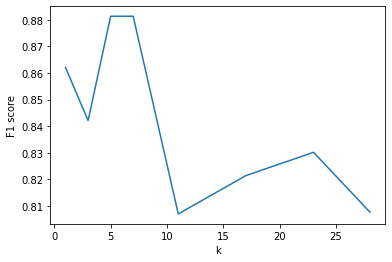

In [57]:
plt.plot(k_values,accuracy_list)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.show()

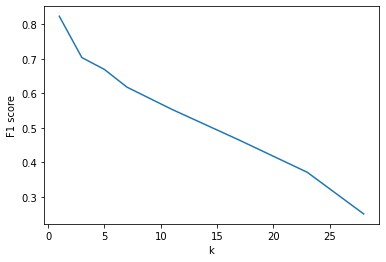

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
k_values=[1,3,5,7,11,17,23,28]
#k_values=[5]
accuracy_list=[]
predicted_labels_list=[]
for k in k_values:
  predicted_labels=k_nearest_neighbours(k,vectors_train,labels_train,vectors_test,metric='euclidean')
  score=accuracy_score(labels_test,predicted_labels)
  tn, fp, fn, tp = confusion_matrix(labels_test, predicted_labels,labels=['ham','spam']).ravel()
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  f1_score=2*(precision*recall)/(precision+recall)
  accuracy_list.append(f1_score)
  predicted_labels_list.append(predicted_labels)
k_values=np.array(k_values)
accuracy_list=np.array(accuracy_list)
plt.plot(k_values,accuracy_list)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("")
plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

In [44]:
tfidf = TfidfVectorizer(tokenizer=lambda x:x, stop_words=None, lowercase=False)    
tf_idf_text = tfidf.fit_transform(data['text'])
x_train, x_test, y_train, y_test = train_test_split(tf_idf_text, data['type'], test_size=0.2, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=3,metric='cosine')
neigh.fit(x_train, y_train)
y_pred_sk=neigh.predict(x_test)
score_display(y_test,y_pred_sk,labels=['ham','spam'])
score=accuracy_score(y_test,y_pred_sk)
print(score)
print(confusion_matrix(y_test, y_pred_sk,labels=['ham','spam']))

Confusion matrix: 
[[949   2]
 [ 34 128]]
Precision: 0.9846153846153847
Recall: 0.7901234567901234
F1 Score: 0.8767123287671232
Accuracy: 0.967654986522911
0.967654986522911
[[949   2]
 [ 34 128]]


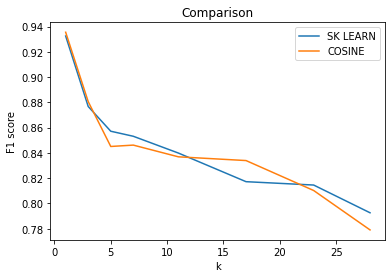

[0.932475884244373, 0.8767123287671232, 0.8571428571428572, 0.8531468531468532, 0.8398576512455516, 0.8172043010752689, 0.8145454545454545, 0.7925925925925926]


In [46]:
k_values=[1,3,5,7,11,17,23,28]
#k_values=[5]
accuracy_list_pred_sk=[]
predicted_labels_list_sk=[]
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k,metric='cosine')
  neigh.fit(x_train,y_train)
  predicted_labels_sk=neigh.predict(x_test)
  tn, fp, fn, tp = confusion_matrix(y_test, predicted_labels_sk,labels=['ham','spam']).ravel()
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  f1_score=2*(precision*recall)/(precision+recall)
  accuracy_list_pred_sk.append(f1_score)
  predicted_labels_list_sk.append(predicted_labels_sk)
plt.plot(k_values,accuracy_list_pred_sk,label="SK LEARN")
plt.plot(k_values,accuracy_list_cosine,label="COSINE")
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("Comparison")
plt.legend()
plt.show()
print(accuracy_list_pred_sk)

In [ ]:
k_values=[1,3,5,7,11,17,23,28]
#k_values=[5]
accuracy_list_pred_sk=[]
predicted_labels_list_sk=[]
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k,metric='cosine')
  neigh.fit(x_train,y_train)
  predicted_labels_sk=neigh.predict(x_test)
  tn, fp, fn, tp = confusion_matrix(y_test, predicted_labels_sk,labels=['ham','spam']).ravel()
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  f1_score=2*(precision*recall)/(precision+recall)
  accuracy_list_pred_sk.append(f1_score)
  predicted_labels_list_sk.append(predicted_labels_sk)
plt.plot(k_values,accuracy_list_pred_sk)
plt.plot(k_values,accuracy_list_cosine)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("")
plt.show()
print(accuracy_list_pred_sk)

***Compare both the models result.***

***What is the time complexity of training using KNN classifier?***

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***